# Initialization

In [1]:
import numpy as np
from tqdm import tqdm
import os
import sys
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
matplotlib.rc('font', size=16)
plt.rcParams['figure.figsize'] = (12.0, 10.0)    # resize plots

import skimpax

/home/aalbers/.conda/envs/pax_jelle/lib/python3.4/site-packages/IPython/kernel/__init__.py:13: ShimWarning: The `IPython.kernel` package has been deprecated. You should import from ipykernel or jupyter_client instead.
  "You should import from ipykernel or jupyter_client instead.", ShimWarning)


If you want to read in an older pax file format, as we'll do here, you have to use this command:

In [ ]:
# If you get weird compilation errors, do rm -rf ~/.cache/rootpy
skimpax.set_data_format('pax', version=412)

Note you can also do 'xerawdp' to load in Xerawdp root files, but some of the details below will be different -- this is (and will likely always be) an experimental feature.

# Getting dataset information

Any analysis starts with selecting datasets. This loads the XENON100 runs info, then makes it available as a pandas dataframe 'datasets'. 

(Internally this loads a CSV file, which is copy-pasted from the wiki's runs database table. For now I've only done run 10. Of course for XENON1T we don't want a static csv file, but a connection to the real runs database.)

In [3]:
from skimpax import datasets, get_dataset_info

In [4]:
get_dataset_info('xe100_120401_2201')

{'anode': 4.4000000000000004,
 'category': 'standard',
 'cathode': 16.0,
 'comment': nan,
 'corrected_events': 22091.0,
 'corrected_livetime': 39603.300000000003,
 'events': 32098,
 'livetime': 39603.300000000003,
 'name': 'xe100_120401_2201',
 'position': 'other',
 'processed': '0.4.5',
 'run': '10',
 'shield': 'closed',
 'source': 'Dark Matter',
 'tpc': 'xenon100',
 'trigger': 'S1'}

Here's an example to get all standard AmBe datasets:

In [5]:
datasets.query('source == "AmBe" & category == "standard"')['name'].values

array(['xe100_110210_1100', 'xe100_110210_1106', 'xe100_110210_1412',
       'xe100_110210_1502', 'xe100_110210_1709', 'xe100_110210_1926',
       'xe100_110210_2211', 'xe100_110210_2341', 'xe100_110211_0059',
       'xe100_110211_0315', 'xe100_110211_0532', 'xe100_110211_0614',
       'xe100_110211_0935', 'xe100_110211_1243', 'xe100_120402_1116',
       'xe100_120402_1415', 'xe100_120402_1727', 'xe100_120402_2000',
       'xe100_120402_2233', 'xe100_120403_0107', 'xe100_120403_0340',
       'xe100_120403_0615', 'xe100_120403_0850', 'xe100_120403_1125',
       'xe100_120403_1400', 'xe100_120403_1634', 'xe100_120403_1910',
       'xe100_120403_2145', 'xe100_120404_0020', 'xe100_120404_0255',
       'xe100_120404_0529', 'xe100_120404_0804'], dtype=object)

This counts the data livetime in days for each source, considering only standard datasets:

In [6]:
standard_datasets = datasets[datasets['category'] == 'standard']
pd.groupby(standard_datasets, 'source')['livetime'].sum() / (3600 * 24)

source
AmBe             3.005850
Co60            22.567252
Cs137            6.230497
Dark Matter    231.763412
Th232           25.638033
Name: livetime, dtype: float64

# Looping over ROOT files

The default pax output format is a ROOT file containing an event class. While you could analyze them with TTree.Draw(...) (in python or C++), you have much more control if you loop over the events. Here is a basic function which allows you to run a custom function of every event in one or more pax root files:

In [7]:
from skimpax import loop_over_dataset, loop_over_datasets, StopEventLoop

Here are two silly examples of using this function. There are much faster ways to do simple things like this, as we will cover below.

Count the number of events with more than 4 S1s in two datasets:

In [8]:
global counter
counter = 0

def count_many_s1s(event):
    global counter
    if len(event.s1s) > 4:
        counter += 1

loop_over_datasets(['xe100_110228_1427', 'xe100_110302_1945'], count_many_s1s)
print("We found %d events with more than 3 S1s" % counter)

We found 875 events with more than 3 S1s


Find the first event whose main s1 area is 70 pe in some dark matter dataset:

In [9]:
def find_s1_70pe(event):
    if not len(event.interactions):
        # Continues to the next event
        # We're in a function, so need to do return rather than continue
        return
    main_interaction = event.interactions[0]
    main_s1 = event.peaks[main_interaction.s1]
    if np.round(main_s1.area) == 70:
        print("Event %s has a main S1 with area %s pe" % (event.event_number, main_s1.area))
        raise StopEventLoop

loop_over_dataset('xe100_120401_2201', find_s1_70pe)

 15%|█▌        | 4905/32098 [00:01<00:05, 5348.28it/s]

Event 4963 has a main S1 with area 70.1126480102539 pe


# Extracting relevant data

Even though you can loop over ROOT files quickly, it is too slow for convenient plotting. Do you have to go back to TTree->Draw(..)? No! 

In [10]:
from skimpax import load_skims

This loads basic data for AmBe. If it's the first time you run it, it can take a while; after that it should be really quick. I'll load in just a few datasets to save time.

In [11]:
my_datasets = datasets.query('source == "AmBe" & category == "standard"')['name'].values
data = load_skims(my_datasets[-3:], 'Basics', skip_if_root_file_not_found=True)

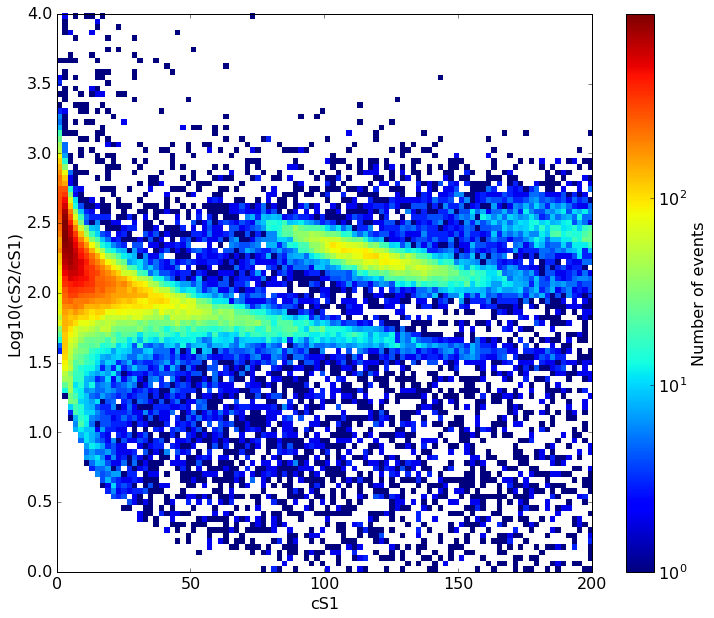

In [12]:
data = data[data['cs1'] > 0]
plt.hist2d(data['cs1'], np.log10(data['cs2']/data['cs1']),
           bins=100, range=((0, 200), (0, 4)), norm=matplotlib.colors.LogNorm())
plt.colorbar(label='Number of events')
plt.xlabel('cS1')
plt.ylabel('Log10(cS2/cS1)')
plt.show()

# Extract new data

Perhaps you find the Basics files don't include all the variables you want. It's easy to create your own Skimmer to get extra variables:

In [13]:
from skimpax import Skimmer

class S1Width(Skimmer):
    # TODO: there seems to be an issue with range_are_decile & SetBranchStatus
    # If you run this it will work, but it's very slow
    extra_branches = ['peaks.hit_time_std', '*range_area_decile*']
    
    def extract_data(self, event):
        if not len(event.interactions):
            return dict()
        s1 = event.peaks[event.interactions[0].s1]
        return dict(s1_hit_time_std=s1.hit_time_std,
                    s1_range_area_decile_5=s1.range_area_decile[5],
                    s1_range_area_decile_9=s1.range_area_decile[9])

You can use this new skimmer alongside the basic skimmer. Data will be appropriately concatenated, and once you've run your skimmer once over a dataset it will cache the results. Again, to save time I'll only load in the last couple of AmBe datasets:

In [14]:
data = load_skims(my_datasets[-3:], ['Basics', S1Width], skip_if_root_file_not_found=True)
data = data[data['cs1'] > 0]
data.head()

,cs1,cs2,event_number,event_time,largest_other_coincidence,largest_other_lone_hit,largest_other_s1,largest_other_s2,largest_other_unknown,x,y,z,s1_hit_time_std,s1_range_area_decile_5,s1_range_area_decile_9
0,180.449540,73692.980023,0,-417532416,NaN,0.986468,8.383761,62.003742,NaN,-3.287594,-13.832706,8.076916,24.125702,28.620667,82.937730
1,7.286613,1056.752925,1,-411239424,NaN,1.880180,NaN,NaN,NaN,-0.682331,-11.847744,18.995636,15.908227,19.517759,59.415130
3,52.490747,657.503033,3,-293418240,NaN,1.827857,NaN,333.485077,NaN,-7.877820,-4.900376,25.463694,19.540237,22.370977,68.862074
5,29.460184,3975.266165,5,-223817216,NaN,1.333779,13.095728,1365.268311,NaN,-1.426692,-2.543233,22.957640,33.768295,21.955559,111.934868
8,1010.626756,123874.088000,8,-15852288,NaN,1.816303,547.331848,92771.578125,NaN,-12.095864,5.148496,11.850575,30.100780,29.336899,88.908842


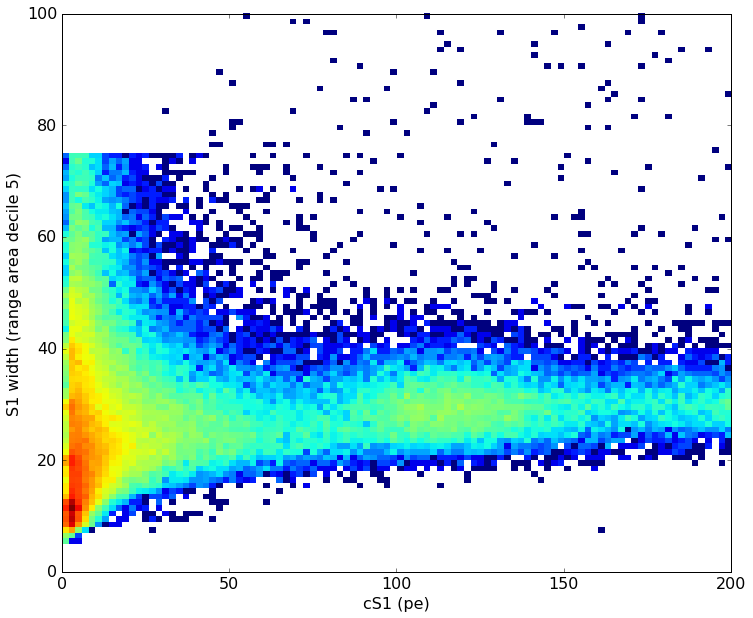

In [15]:
plt.hist2d(data['cs1'], data['s1_range_area_decile_5'], bins=100,
           range=((0, 200), (0, 100)), norm=matplotlib.colors.LogNorm())
plt.xlabel('cS1 (pe)')
plt.ylabel('S1 width (range area decile 5)')
plt.show()